# Toronto Bike Sharing Analysis by Neighbourhood

### Background

This data, representing all bike trips conducted through the city of Toronto's bike share network from Jan 2020 to Oct 2020, is available through the City of Toronto's Open Data Portal, [here](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/). 

### Analysis

The first section analyzes differences in bike usage behaviour between different neighbourhoods in Toronto. This section investigates two types of possible bikes trips, 'leisure' and 'commutes', as well as attempt to create clusters of bike stations with similar ridership patterns. Then, these clusters (representing neighbourhoods) will be analyzed for trends, and some plausible explainations will be presented and tested. 

As a result of this analysis, certain questions based on pre-existing assumptions will be tested:
* Are there any patterns in the type and characteristic of bike trips between different neighbourhoods?
* Do waterfront neighbourhoods have a disproportionate number of leisure-related bike trips compared to others?
* Do downtown neighbourhoods have a disproportionate number of commuters compared to others?

We'll be using several tools including Numpy, Pandas, Scikit-Learn, and Matplotlib to answer these questions.

### Model

The second section is a personal experiment using the anonymized dataset provided by the city of Toronto. It attempts to create a machine learning model to predict a subscriber's destination based on known characteristics at time of departure (time of day, day of the week, station, geographic coordinates etc).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Load data from csv source

[Toronto Open Data](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/)

In [559]:
dfs = {}

for i in range(1,10):
    file_name = str.format('2020-0{}', i)
    dfs[file_name] = pd.read_csv(str.format('./2020-bike-share/{}.csv', file_name))

for i in range(0,1):
    file_name = str.format('2020-1{}', i)
    dfs[file_name] = pd.read_csv(str.format('./2020-bike-share/{}.csv', file_name))

df = pd.concat(dfs, ignore_index=True)

#### Preliminary Cleaning

In [28]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612704 entries, 0 to 2612703
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Trip Id             int64  
 1   Subscription Id     int64  
 2   Trip  Duration      int64  
 3   Start Station Id    int64  
 4   Start Time          object 
 5   Start Station Name  object 
 6   End Station Id      float64
 7   End Time            object 
 8   End Station Name    object 
 9   Bike Id             int64  
 10  User Type           object 
dtypes: float64(1), int64(5), object(5)
memory usage: 219.3+ MB
Trip Id                 0
Subscription Id         0
Trip  Duration          0
Start Station Id        0
Start Time              0
Start Station Name    164
End Station Id        812
End Time                0
End Station Name      954
Bike Id                 0
User Type               0
dtype: int64
Princess St / Adelaide St E                    390
Front St E / Scott St                       

In [561]:
# Since we have more than 1 million rows, just drop the null station data rows
df = df.dropna()

# For faster debugging, I randomly sample 1/10th of the actual dataset.
# Can uncomment when running the full model
df = df.sample(frac=0.1)

len(df)

783478

### Merge with static station data

Pull latlngs of stations from Toronto Data [API](https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information)

In [562]:
import requests
import json

resp = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
stations = pd.read_json(json.dumps(resp.json()['data']['stations']))
stations = stations.set_index('station_id')

### Initial Data Cleaning & Preprocessing

* Add Station Latitude and Longitude to understand each station's geographic location in Toronto relative to each other
* Convert timestamp strings into datetime objects
* Adding duration of ride using timestamps

In [565]:
# print(stations)
s = set(stations.index.values)

df['Start Station Lat'] = df['Start Station Id'].apply(lambda x: stations.loc[x]['lat'] if x in s else -1)
df['Start Station Lng'] = df['Start Station Id'].apply(lambda x: stations.loc[x]['lon'] if x in s else -1)

In [566]:
df['End Station Lat'] = df['End Station Id'].apply(lambda x: stations.loc[x]['lat'] if x in s else -1)
df['End Station Lng'] = df['End Station Id'].apply(lambda x: stations.loc[x]['lon'] if x in s else -1)

In [567]:
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['End Time'] = pd.to_datetime(df['End Time'])

In [670]:
def get_duration(end, start):
    (end - start).total_seconds()

# Duration in seconds
df['Duration'] = (df['End Time'] - df['Start Time']).apply(lambda x: x.total_seconds())

In [578]:
# Quick DF Cleanup from the invalid station latlngs
df = df[(df['Start Station Lat'] != -1) & (df['End Station Lat'] != -1)]

*This process can take a long time with 2 million rows, so save dataframe*

In [579]:
df.to_csv('./checkpoints/checkpoint_1.csv')

In [ ]:
# df = pd.read_csv('./checkpoints/checkpoint_1.csv')

## Overview

One way to think about bike trips is the path, described by a start and end destination. We can derive 2 types of trips from that information. `One-way trips`, where the terminal stations are not the same, and `round trips`, where the terminal stations have the same identifier.

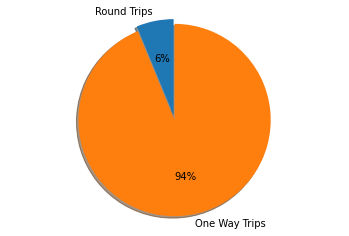

In [672]:
round_trip = df[df['Start Station Id'] == df['End Station Id']]
one_way_trip = df[df['Start Station Id'] != df['End Station Id']]

labels = ['Round Trips', 'One Way Trips']
sizes = [len(round_trip), len(one_way_trip)]
explode = (0, 0.05)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%1.0f%%', startangle=90)
ax1.axis('equal') 

plt.show()

## Round Trips

### Definition of a *round trip*

Defining a round trip as a trip with the same start and end station id, we see that roughly 6% of trips are round trips. 

This leads to several questions. Why and where would these users have a round trip? If it was for a morning and evening commute, this would be broken into at least two trips (which we attempt to track later). Two possible explainations could be **(1)** an 'accidental unlock', and **(2)** a visitor or a tourist sightseeing.

We can define "accidental unlocks", where the rider unlocks and then relocks a bike, to be a ride shorter than or equal to 1 minute, because the open and close timestamp works at the minute resolution.

#### Note on the histogram

To properly show a histogram of ride durations, we must drop some outlier values since the max datapoint is 10806 minutes; more than 1 whole day! Thus, we will plot 2 graphs at the 99-%tile and 95-%tile.

3.85% of trips are shorter than or equal to 1 minute
count    48652.000000
mean        46.059607
std        127.132901
min          0.000000
25%         13.000000
50%         25.000000
75%         47.000000
max       8046.000000
Name: Duration, dtype: float64
Taking 48165 rows for 99 percentile
Taking 45757 rows for 95 percentile
31.52% of trips are longer than 30 minutes
14.66% of trips are longer than 60 minutes


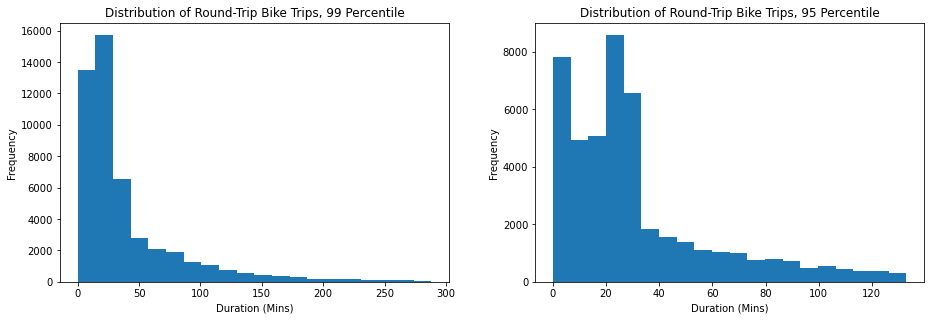

In [673]:
# Only 4% of round trips are "accidents"
print(str.format('{}% of trips are shorter than or equal to 1 minute', "{:.2f}".format(100 * len(round_trip[round_trip['Duration'] <= 60]) / len(round_trip))))

duration_mins = round_trip['Duration'] / 60
print(duration_mins.describe())

print(str.format('Taking {} rows for 99 percentile', round(len(duration_mins) * 0.99)))
duration_mins = duration_mins.sort_values().head(round(len(duration_mins) * 0.99))

fig = plt.figure() 

axes = fig.add_axes([0,0,0.9,0.9]) 
axes.hist(x=duration_mins, bins=20)
axes.set_xlabel('Duration (Mins)')
axes.set_ylabel('Frequency')
axes.set_title('Distribution of Round-Trip Bike Trips, 99 Percentile')

print(str.format('Taking {} rows for 95 percentile', round(len(duration_mins) * 0.95)))
duration_mins = duration_mins.sort_values().head(round(len(duration_mins) * 0.95))
axes = fig.add_axes([1.1,0,0.9,0.9]) 
axes.hist(x=duration_mins, bins=20)
axes.set_xlabel('Duration (Mins)')
axes.set_ylabel('Frequency')
axes.set_title('Distribution of Round-Trip Bike Trips, 95 Percentile')

print(str.format('{}% of trips are longer than 30 minutes', "{:.2f}".format(100 * len(duration_mins[duration_mins > 30]) / len(duration_mins))))
print(str.format('{}% of trips are longer than 60 minutes', "{:.2f}".format(100 * len(duration_mins[duration_mins > 60]) / len(duration_mins))))

#### Comments

From the analysis above, we see that ~4% of rides fit this definition while the vast majority do not. At least 75% of rides are longer than 13 minutes while the median ride is 25 minutes long. Interesingly, according to Toronto BikeShare, overage fees are charged for any ride lasting longer than 30 minutes! Over 25% of reported riders take overage fees: https://bikesharetoronto.com/ .

Although the vast majority of rides end before 30 minutes to avoid the overage fee, roughly 15% ride between 30 and 60 minutes. 

Based on the Toronto Bike Share pricing model, an overage fee is \\$4 per 30 minutes and a single ride starts at \\$3.75, whereas a day pass is \$7. This seemingly large number could be plausibly explained if a rider only rides for 60 minutes, it would be slightly more economically viable to simply take one overage charge. It would fail to explain the 14\% of riders who ride over 60 minutes, where there is no economic viability.

Although, we do not have a way to find out what pass was purchased, we can use the `User Type` field, as a proxy. The assumption being, tourists and infrequent visitors are less likely to purchase annual member passes.

Casual Member    11350
Annual Member     4724
Name: User Type, dtype: int64
Annual Member    315
Casual Member    262
Name: User Type, dtype: int64
Annual Member    165552
Casual Member     95607
Name: User Type, dtype: int64


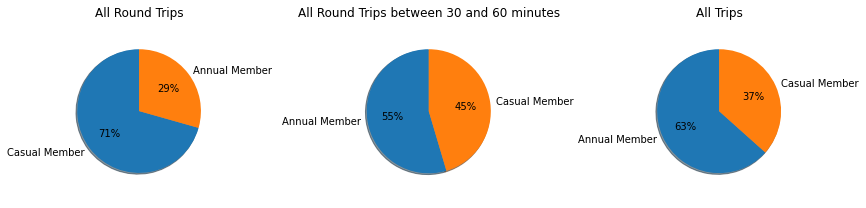

In [155]:
all_round = round_trip['User Type'].value_counts()
one_overage = round_trip[(round_trip['Duration'] <= 60) & (round_trip['Duration'] >= 30)]['User Type'].value_counts()
all_trips = df['User Type'].value_counts()

# print(all_round)
# print(one_overage)
# print(all_trips)

explode = (0, 0)  
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

axes[0].pie(all_round, explode=explode, labels=['Casual Member', 'Annual Member'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[0].axis('equal') 
axes[0].set_title('All Round Trips')

axes[1].pie(one_overage, explode=explode, labels=['Annual Member', 'Casual Member'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[1].axis('equal') 
axes[1].set_title('All Round Trips between 30 and 60 minutes')

axes[2].pie(all_trips, explode=explode, labels=['Annual Member', 'Casual Member'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[2].axis('equal') 
axes[2].set_title('All Trips')

plt.tight_layout()

It appears that round trips are disproportionately done by casual members, based on the All Round Trips and All Trips result. This furthers the possibility that round-trips are mostly done by tourists or infrequent riders (AKA non-commute, leisure purposes).

Contrary to my initial assumption based on unit-economics of a day pass, it appears that more annual members pay overage fees between 30 and 60 minutes compared to casual members. Although this is still comprised of a disproportionate number of casual members, the proportion of annual member can't be explained by unit-economics.

### Geographic Analysis

Since accidental unlocks are a small slice of the total number of round trips, we can start using the LatLng data from the bike station API to understand the distribution of stations across the city, and the number of round trips serviced over the 10 month period.

In [4]:
import seaborn as sns

<AxesSubplot:xlabel='Start Station Lng', ylabel='Start Station Lat'>

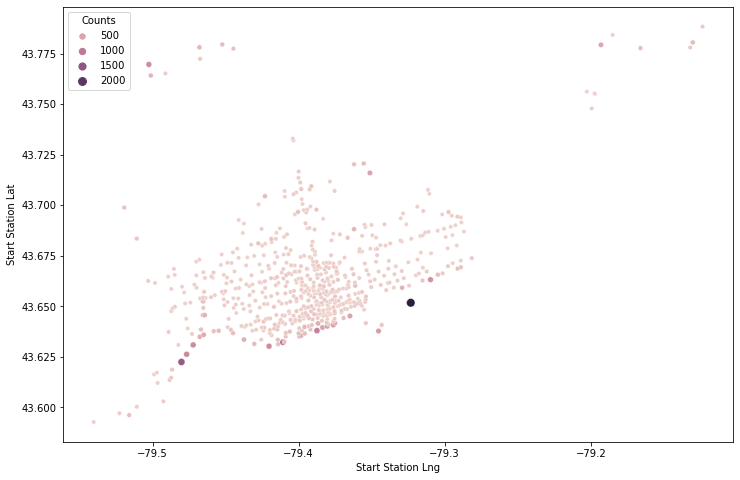

In [675]:
plt.figure(figsize=(12,8))

counts = round_trip.groupby('Start Station Id').count()['User Type']
counts.name = 'Counts'
latlngs = round_trip.groupby('Start Station Id').first()[['Start Station Lat', 'Start Station Lng']]
summary = pd.concat([counts, latlngs], axis=1)

# 2 Stations have -1 latlngs which must be dropped as errors
summary = summary.sort_values(by='Start Station Lat')[2:]
sns.scatterplot(x='Start Station Lng',y='Start Station Lat',data=summary, hue='Counts', size='Counts')

<AxesSubplot:xlabel='Start Station Lng', ylabel='Start Station Lat'>

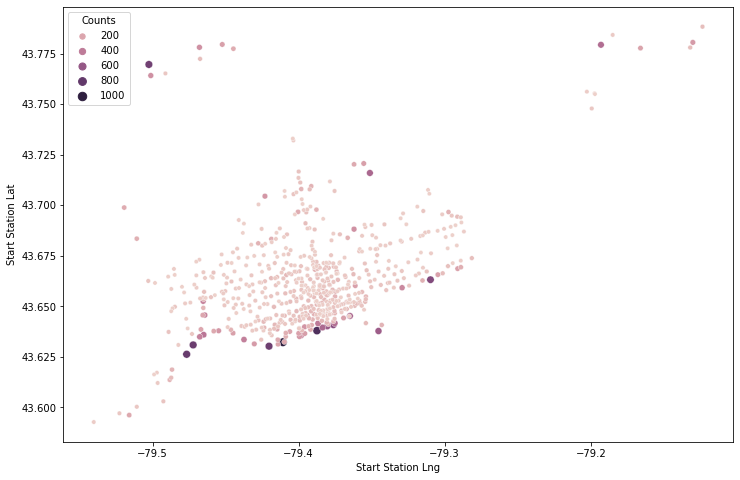

In [676]:
plt.figure(figsize=(12,8))

counts = round_trip.groupby('Start Station Id').count()['User Type']
counts.name = 'Counts'
latlngs = round_trip.groupby('Start Station Id').first()[['Start Station Lat', 'Start Station Lng']]
summary = pd.concat([counts, latlngs], axis=1)

# 2 Stations have -1 latlngs which must be dropped as errors
summary = summary.sort_values(by='Start Station Lat')[2:]

# Drop the first 2 values to show a finer resolution of everything else
summary = summary.sort_values(by='Counts', ascending=False)[2:]
sns.scatterplot(x='Start Station Lng',y='Start Station Lat',data=summary, hue='Counts', size='Counts')

#### Comments

From a quick glance, we see that many stations with high concentrations of round trips are situated along Toronto's waterfront. The waterfront is one of Toronto's most densely populated areas, contains many bike trails, and has a large number of tourist attractions. This could suggest that a large number of round trip users do so for infrequent purposes such as leisure and exploration.

Given the thousands of stations, it's difficult to categorize them into neighbourhood or regional clusters which could help us pursue more quantitiative but less granular analysis. One next step would be to cluster these stations into general neighbourhoods for easier management.

### Purely Geographic K Means Clustering of Stations

Since there is no easy way to map named neighbourhoods of Toronto with their LatLng bounding boxes, Scikit-Learn was used to conduct K Means Clustering.

The stations were partitioned into 20 clusters such that each cluster covers reasonable geographic area, similar to a colloquially known neighbourhood of Toronto.

In [5]:
from sklearn.cluster import KMeans

In [677]:
stations = stations[['lat', 'lon']]
stations['id'] = stations.index

In [678]:
kmeans = KMeans(n_clusters=20)
kmeans.fit(stations[['lat', 'lon']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [680]:
stations['cluster'] = kmeans.labels_

<AxesSubplot:xlabel='lon', ylabel='lat'>

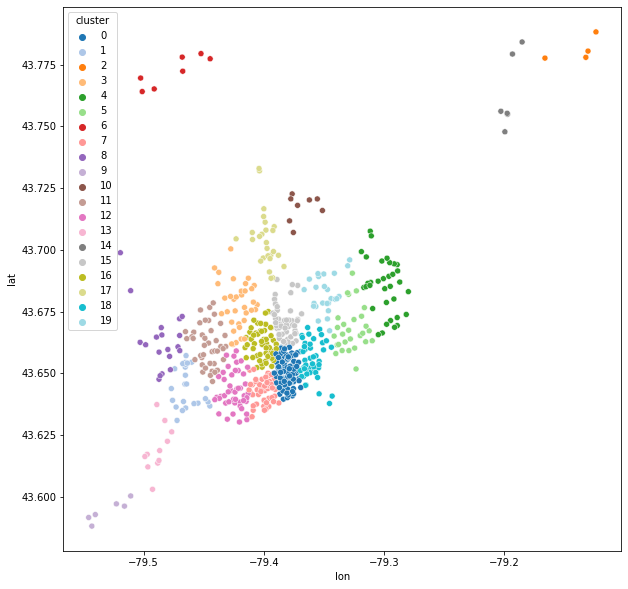

In [682]:
plt.figure(figsize=(10,10)) 
sns.scatterplot(x='lon', y='lat', data=stations, hue='cluster', legend='full', palette='tab20')

#### Comments

One issue with this result is that the clusters still cover fairly broad and evenly divided geographic areas, especially in the downtown area. This may fail to capture the uniqueness of certain neighbourhoods. 

For example, the clusters adjacent to the waterfront, stretch numerous blocks inland, even though our stated assumption and the heat map of round trips suggest that people behave differently directly next to the waterfront. 

One possible way to account for this is to incorporate other data into the clustering process such as the number of departures from a station, rather than purely geographical features. 

To do this, we would have to normalize all the values. Greater weight is applied to LatLng coordinates to maintain a neighbourhood's geographic continuitiy (1:3:3 - trips:lat:lng)

In [683]:
by_station = df.groupby(['Start Station Id', 'Start Station Lat', 'Start Station Lng']).count()['Trip Id']
by_station = pd.DataFrame(by_station).reset_index()
by_station.columns = ['Id', 'Lat', 'Lng', 'Count']

In [146]:
from sklearn.preprocessing import MinMaxScaler

In [688]:
scaler = MinMaxScaler()

# Now that we are using different units, scale them all.

by_station['nlat'] = 3 * scaler.fit_transform(np.array(by_station['Lat'].values).reshape(-1,1))
by_station['nlng'] = 3 * scaler.fit_transform(np.array(by_station['Lng'].values).reshape(-1,1))
by_station['ncount'] = scaler.fit_transform(np.array(by_station['Count'].values).reshape(-1,1))

print(by_station[['nlat', 'nlng', 'ncount']])

kmeans = KMeans(n_clusters=20)
kmeans.fit(by_station[['nlat', 'nlng', 'ncount']])

         nlat      nlng    ncount
0    0.775382  1.064636  0.518353
1    0.895208  1.244044  0.250287
2    1.187400  1.039951  0.274604
3    1.184778  1.016281  0.160817
4    1.025370  1.113331  0.150837
..        ...       ...       ...
595  0.989511  0.583831  0.007341
596  1.380277  1.467487  0.006997
597  1.062379  0.760879  0.013306
598  0.882665  1.244267  0.018697
599  1.471439  0.764248  0.000000

[600 rows x 3 columns]


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [689]:
by_station['category'] = kmeans.labels_

<AxesSubplot:xlabel='Lng', ylabel='Lat'>

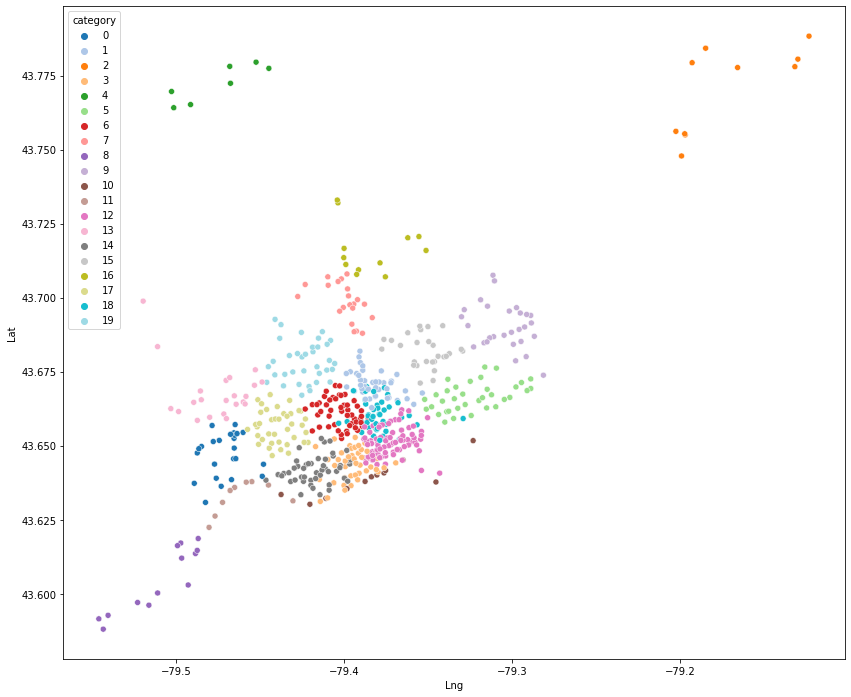

In [690]:
plt.figure(figsize=(14,12)) 
sns.scatterplot(x='Lng', y='Lat', data=by_station, hue='category', legend='full', palette='tab20')

#### Comments

By incorporation a small weighting of bike unlocks into our clustering, we have been able to maintain relatively contiguous blocks.

However, the largest difference is in the distribution of clusters. As we can see from both the brown (#10) and pink (#12), a series of clusters have formed along the waterfront, which was the intended effect based on prior intuition and the ride density scatterplot. For our analysis, we will use the second set of weighted clustering results.

### Incorporating Clusters into the Analysis

In [687]:
lookup = by_station.set_index('Id')
df['Cluster'] = df['Start Station Id'].apply(lambda id: lookup.loc[id, 'category'])

*For slow computers, save as checkpoint*

In [277]:
df.to_csv('./checkpoints/checkpoint_2.csv')

In [6]:
df = pd.read_csv('./checkpoints/checkpoint_2.csv')

### Observations

**Note that the specific numbers may vary depending on the clustering, and the random sample derived**

* Clusters 11, 10, 12, 1 are directly on the waterfront.
* Clusters 5, 18, 0 can be considered 'waterfront adjacent'.
* The clusters above with the inclusion of 2, 9, 7, 15, and 19 can be considered 'downtown'.

We can use these loose definitions to analyze some general neighbourhood trends.

0.35% of round trips occur in waterfront neighbourhoods accounting for 0.09% of stations
0.59% of round trips occur in waterfront & adjacent neighbourhoods accounting for 0.37% of stations
0.78% of round trips occur in downtown neighbourhoods accounting for 0.68% of stations


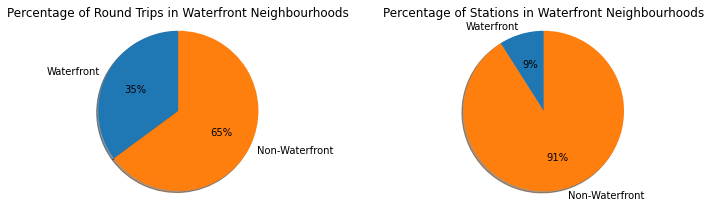

In [291]:
round_trip = df[df['Start Station Id'] == df['End Station Id']]
total_stations = len(round_trip['Start Station Id'].unique())

waterfront = round_trip[(round_trip['Cluster'] == 11) | 
                        (round_trip['Cluster'] == 10) | 
                        (round_trip['Cluster'] == 12) | 
                        (round_trip['Cluster'] == 1)]

num = len(waterfront['Start Station Id'].unique())

print(str.format('{}% of round trips occur in waterfront neighbourhoods accounting for {}% of stations', 
                 "{:.2f}".format(len(waterfront) / len(round_trip)), 
                 "{:.2f}".format(num / total_stations)))


waterfront_adj = round_trip[(round_trip['Cluster'] == 11) | 
                            (round_trip['Cluster'] == 10) | 
                            (round_trip['Cluster'] == 12) | 
                            (round_trip['Cluster'] == 1) | 
                            (round_trip['Cluster'] == 5) | 
                            (round_trip['Cluster'] == 18) | 
                            (round_trip['Cluster'] == 0)]

num = len(waterfront_adj['Start Station Id'].unique())

print(str.format('{}% of round trips occur in waterfront & adjacent neighbourhoods accounting for {}% of stations', 
                 "{:.2f}".format(len(waterfront_adj) / len(round_trip)), 
                 "{:.2f}".format(num / total_stations)))

downtown = round_trip[(round_trip['Cluster'] == 11) | 
                            (round_trip['Cluster'] == 10) | 
                            (round_trip['Cluster'] == 12) | 
                            (round_trip['Cluster'] == 1) | 
                            (round_trip['Cluster'] == 5) | 
                            (round_trip['Cluster'] == 18) | 
                            (round_trip['Cluster'] == 0) | 
                            (round_trip['Cluster'] == 2) | 
                            (round_trip['Cluster'] == 9) | 
                            (round_trip['Cluster'] == 7) | 
                            (round_trip['Cluster'] == 15) | 
                            (round_trip['Cluster'] == 19)]

num = len(downtown['Start Station Id'].unique())

print(str.format('{}% of round trips occur in downtown neighbourhoods accounting for {}% of stations', 
                 "{:.2f}".format(len(downtown) / len(round_trip)), 
                 "{:.2f}".format(num / total_stations)))


explode = (0, 0)  
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

waterfront_trips = len(waterfront)
other_trips = len(round_trip) - len(waterfront)

waterfront_stations = len(waterfront['Start Station Id'].unique())
other_stations = total_stations - waterfront_stations

axes[0].pie([waterfront_trips, other_trips], explode=explode, labels=['Waterfront', 'Non-Waterfront'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[0].axis('equal') 
axes[0].set_title('Percentage of Round Trips in Waterfront Neighbourhoods')

axes[1].pie([waterfront_stations, other_stations], explode=explode, labels=['Waterfront', 'Non-Waterfront'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[1].axis('equal') 
axes[1].set_title('Percentage of Stations in Waterfront Neighbourhoods')

plt.tight_layout()

### Comments

As we suspected, waterfront neighbourhoods make up a disproportionate amount of round trips relative to their number of stations (~4x).

A valid question may be whether waterfront communities are just more dense and have a higher resident to bike station ratio (since it is also in Toronto's downtown area).

We can gain clarity with respect to this question in 2 ways:

1. Have a clearer picture of one-way trips in Waterfront properties. If the issue is simply population density, then one-way trips should exhibit the same disproportionate behaviour. 

2. Have a clearer picture of round trips in similar density neighbourhoods, such as cluster 18 (roughly, the downtown financial district). If the issue is simply population density, then round trips should exhibit the same behaviour. 

Note, that since we now consider one-way trips, we would actually be analyzing the amount of departures from waterfront neighbourhoods as a proportion to all depatures.

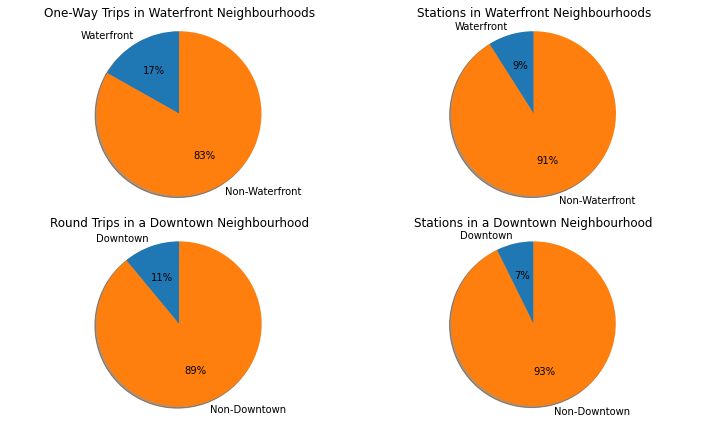

In [302]:
explode = (0, 0)  
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

# Waterfront

one_way = df[df['Start Station Id'] != df['End Station Id']]
total_stations = len(one_way['Start Station Id'].unique())

waterfront = one_way[(one_way['Cluster'] == 11) | 
                (one_way['Cluster'] == 10) | 
                (one_way['Cluster'] == 12) | 
                (one_way['Cluster'] == 1)]

waterfront_trips = len(waterfront)
other_trips = len(one_way) - len(waterfront)

waterfront_stations = len(waterfront['Start Station Id'].unique())
other_stations = total_stations - waterfront_stations

axes[0,0].pie([waterfront_trips, other_trips], explode=explode, labels=['Waterfront', 'Non-Waterfront'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[0,0].axis('equal') 
axes[0,0].set_title('One-Way Trips in Waterfront Neighbourhoods')

axes[0,1].pie([waterfront_stations, other_stations], explode=explode, labels=['Waterfront', 'Non-Waterfront'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[0,1].axis('equal') 
axes[0,1].set_title('Stations in Waterfront Neighbourhoods')

# Downtown
total_stations = len(round_trip['Start Station Id'].unique())

downtown = round_trip[(round_trip['Cluster'] == 18)]

downtown_trips = len(downtown)
other_trips = len(round_trip) - len(downtown)

downtown_stations = len(downtown['Start Station Id'].unique())
other_stations = total_stations - downtown_stations

axes[1,0].pie([downtown_trips, other_trips], explode=explode, labels=['Downtown', 'Non-Downtown'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[1,0].axis('equal') 
axes[1,0].set_title('Round Trips in a Downtown Neighbourhood')

axes[1,1].pie([downtown_stations, other_stations], explode=explode, labels=['Downtown', 'Non-Downtown'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[1,1].axis('equal') 
axes[1,1].set_title('Stations in a Downtown Neighbourhood')

plt.tight_layout()

### Observations

1. The same disparity in trips cannot be found for one-way trips departing waterfront neighbourhoods (2x compared to 4x). 
2. The disproportionate number of round trips cannot be found is adjacent and similar density neighbourhoods.

By looking at possible confounding factors, this would indicate that there are indeed unique characteristics of ridership behaviour in waterfront neighbourhoods of Toronto. Potentially attributed to the number of tourist attractions, bike trails, and scenery which draws a disproportinate number of visitors looking for a leisurely bike ride.

## One-Way Trips

The second analysis revolves around a "commute", which introduces several questions in and of itself.

* How can we define a commute?
* How common are these commutes relative to the total number of trips?
* Do some neighbourhoods have more commutes than others?

### Defining a commute

First, we need to make a few assumptions about how we consider commutes. We can think of a worker who rides a bike in the morning from home to a place of work as a commute trip. We can consider a ride in the afternoon from work back home as another commute trip. These activities would occur on the same day, and would be recorded as two distinct bike trips. If the user purchases an annual pass, this would be visible as an `Annual Member` user type with the same `Subscription Id`. Since we do not know the exact intent of every bike rider, we will require several proxies in our definition.

We can call a _pair_ of trips "a commute" if:
1. They share the same `subscription id` (relating to the same user, of type `annual member`)
2. They have complimentary start and end station ids (the start id of one trip, is the end if of the other trip)
3. Their date posses the same day (reflective of biking to work and biking home)

### Potential Issues

Some discrepancies with an intuitive definition of commute may arrise in this analysis.

It would fail to account for a commuter who does not have `annual membership`. This definition could be a reasonable compromise as most commuters will find it economical to purchase an annual pass, however considering the seasonality of Toronto weather, it's possible members may not purchase "annual membership". Unfortunately, the dichotomy of user types doesn't allow for any greater granular analysis on this feature.  

It is also possible that this definition may undercount commutes if the user does not return to the exact same station at the end of the day. This may be quite possible for areas with many bike stations, or if the user goes somewhere else after work. It could be possible to address both these use cases with two approaches:
1. We can have a finer resolution geographic "start cluster", and "end cluster" which could be a collection of several nearby stations. Then, a commute can be defined as having complementary start and end clusters. 
2. We can simply look for the existence of an End Station Id which equals a corresponding Start Station Id provided they exist on the same day. For example, if a worker goes A->B (to work), B->C (after work), C->A (back home), since the End Station 'A' equals the Start Station 'A' on the same day, we can still define A->B and C->A as a commute.
For the sake of simplicity in this initial analysis, we will not be applying these two factors into the criteria.

This definition may over count commutes in situations where a user bikes somewhere for leisure only to return home afterwards. One way to mitigate is to use certain assumptions about the common work day (Monday to Friday) to mitigate that possibility, however without a more precise estimate of how many trips fit this use-case, a filter like that would be layering an additional assumption into this definition.

In [570]:
df['Month-Day'] = df['Start Time'].apply(lambda x: str.format('{}-{}', x.month, x.day))

In [691]:
groups = pd.DataFrame(df[df['User Type'] == 'Annual Member'].groupby(['Subscription Id', 'Month-Day', 'Start Station Id', 'End Station Id']).count()['Trip Id'])
groups.columns = ['Departures']
groups = groups.reset_index(level=['Start Station Id', 'End Station Id'])

# Use a join to match start station with end station (criteria #2)
commutes = pd.merge(groups, groups, left_on=['Start Station Id', 'End Station Id', 'Subscription Id', 'Month-Day'], right_on=['End Station Id', 'Start Station Id', 'Subscription Id', 'Month-Day'], how='inner')

commutes = commutes.drop(['Start Station Id_x', 'End Station Id_x'], axis=1)
commutes['Departures'] = commutes['Departures_x'] + commutes['Departures_y']
commutes = commutes.drop(['Departures_x', 'Departures_y'], axis=1)
commutes.columns = ['Terminal_Station_Id_One', 'Terminal_Station_Id_Two', 'Departures']

commutes

Terminal_Station_Id_One  Terminal_Station_Id_Two  \
Subscription Id Month-Day                                                     
66217           10-10                         7514                   7514.0   
                10-11                         7430                   7226.0   
                10-11                         7317                   7317.0   
                10-11                         7226                   7430.0   
                10-12                         7576                   7283.0   
...                                            ...                      ...   
842844          10-29                         7188                   7249.0   
842973          10-7                          7000                   7000.0   
843062          10-13                         7096                   7096.0   
                10-14                         7096                   7096.0   
                10-7                          7096                   7096.0   

                           Departures  
Subscription Id Month-Day              
66217           10-10               2  
                10-11               2  
                10-11               2  
                10-11               2  
                10-12               2  
...                               ...  
842844          10-29               2  
842973          10-7                2  
843062          10-13               2  
                10-14               2  
                10-7                2  

[41585 rows x 3 columns]

In [128]:
tot_rides = groups['Departures'].sum()
num_coms = commutes['Departures'].sum()

print('{} rides are commutes which is {:.2f}% of total rides by annual members.'.format(num_coms, 100 * num_coms / tot_rides))

15554 rides are commutes which is 9.44% of total rides by annual members.


<AxesSubplot:xlabel='lng', ylabel='lat'>

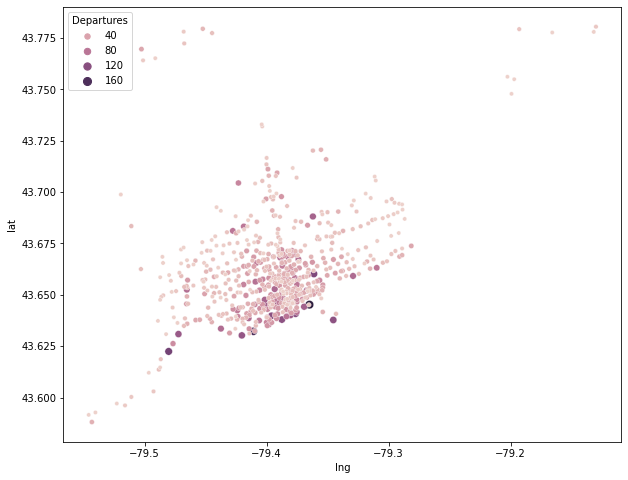

In [145]:
plt.figure(figsize=(10,8))

activity = commutes[['Terminal_Station_Id_One', 'Departures']].reset_index().drop(['Subscription Id', 'Month-Day'], axis=1).groupby('Terminal_Station_Id_One').sum()
activity.index.name = 'Terminal Station'

activity['id'] = activity.index
activity['lat'] = activity['id'].apply(lambda x: stations.loc[x, 'lat'])
activity['lng'] = activity['id'].apply(lambda x: stations.loc[x, 'lon'])

# Drop one outlier station with a value 494.
sns.scatterplot(x='lng',y='lat',
                data=activity.sort_values(by='Departures', ascending=False)[1:], 
                hue='Departures', size='Departures')


#### Comments

With our current version of a commute, we see that commutes account for roughly 10% of all trips. From a quick visualization, they appear to be concentrated around the waterfront and downtown areas of Toronto (similar to before). We can apply a similar clustering method as one-way trips to analyze neighbourhoods.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [155]:
scaler = MinMaxScaler()

# Now that we are using different units, scale them all.

activity['nlat'] = 3 * scaler.fit_transform(np.array(activity['lat'].values).reshape(-1,1))
activity['nlng'] = 3 * scaler.fit_transform(np.array(activity['lng'].values).reshape(-1,1))
activity['ncount'] = scaler.fit_transform(np.array(activity['Departures'].values).reshape(-1,1))

kmeans = KMeans(n_clusters=20)
kmeans.fit(activity[['nlat', 'nlng', 'ncount']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [156]:
activity['category'] = kmeans.labels_

<AxesSubplot:xlabel='lng', ylabel='lat'>

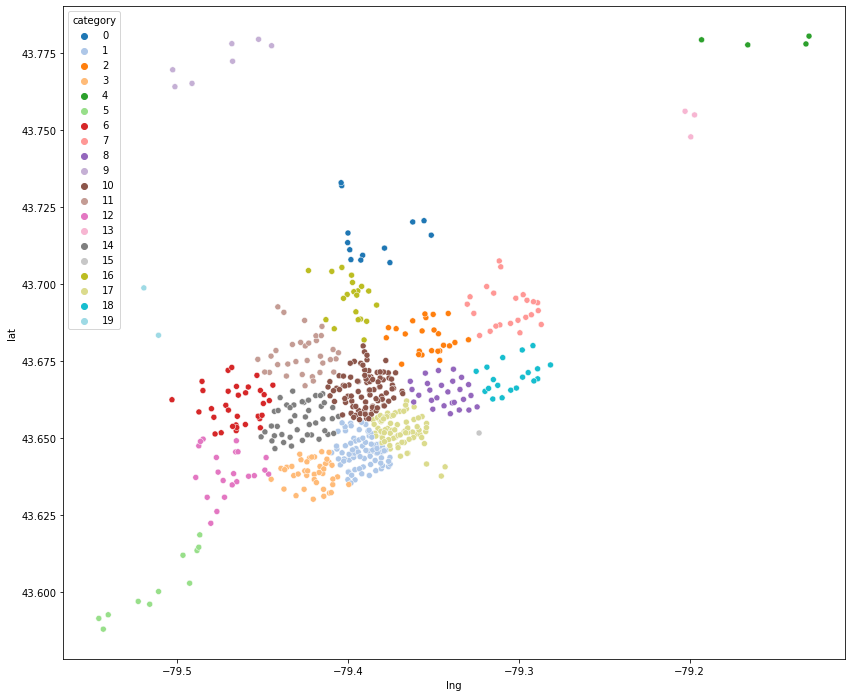

In [157]:
plt.figure(figsize=(14,12)) 
sns.scatterplot(x='lng', y='lat', data=activity, hue='category', legend='full', palette='tab20')

### Comments

**Note, specific cluster numbers may vary on each run. You can use a random seed for consistency.**

Compared to one-way trips, using the same weighting of count and geographic coordinates (1:3:3), there does not appear to be a similar discrepancy of behaviour along the waterfront compared to other neighbourhoods in Toronto. The sole exception is cluster 15, which is represented as a single station along the waterfront. This station received over 400 commutes and was dropped as an outlier for a cleaner variation earlier, which may explain why it exists as it's own unique cluster. 

Using the same method as before, we can group clusters together and analyze the share of commutes from Downtown Toronto compared to other neighbourhoods. Using Google Maps as a reference, we will classify clusters 3, 1, 17, and 8 as "Downtown".

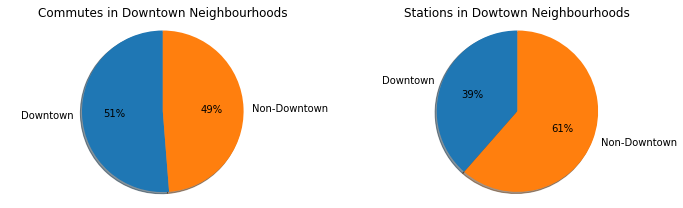

In [163]:
explode = (0, 0)  
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
total_stations = len(activity)

# Downtown

downtown = activity[(activity['category'] == 3) | 
                (activity['category'] == 1) | 
                (activity['category'] == 17) | 
                (activity['category'] == 8)]

downtown_commutes = downtown['Departures'].sum()
other_commutes = activity['Departures'].sum() - downtown_commutes

downtown_stations = len(downtown)
other_stations = total_stations - downtown_stations

axes[0].pie([downtown_commutes, other_commutes], explode=explode, labels=['Downtown', 'Non-Downtown'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[0].axis('equal') 
axes[0].set_title('Commutes in Downtown Neighbourhoods')

axes[1].pie([downtown_stations, other_stations], explode=explode, labels=['Downtown', 'Non-Downtown'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[1].axis('equal') 
axes[1].set_title('Stations in Dowtown Neighbourhoods')

plt.tight_layout()

#### Comments

From the pie chart, it appears that Downtown neighbourhoods do have a disproportionate number of commutes, but only by roughly an additional 25% of their portion of stations. This could be plausible as there are more bike lanes, and generally greater car congestion in Downtown Toronto compared to more suburban areas; this may incentivize residents to bike as opposed to using other means of transporation. We can analyze commutes in other neighbourhoods to get a better sense of this statistic.

* Clusters 10 and 14 correspond roughly to Midtown 
* Clusters 18 and 7 correspond roughly to East York

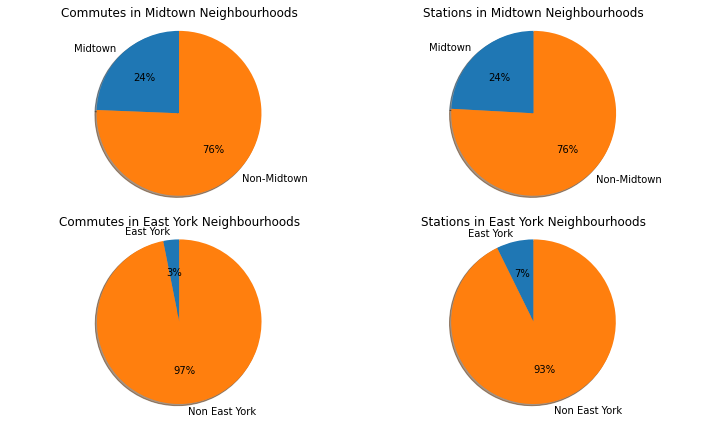

In [165]:
explode = (0, 0)  
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
total_stations = len(activity)

# Midtown

midtown = activity[(activity['category'] == 10) | 
                (activity['category'] == 14)]

midtown_commutes = midtown['Departures'].sum()
other_commutes = activity['Departures'].sum() - midtown_commutes

midtown_stations = len(midtown)
other_stations = total_stations - midtown_stations

axes[0,0].pie([midtown_commutes, other_commutes], explode=explode, labels=['Midtown', 'Non-Midtown'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[0,0].axis('equal') 
axes[0,0].set_title('Commutes in Midtown Neighbourhoods')

axes[0,1].pie([midtown_stations, other_stations], explode=explode, labels=['Midtown', 'Non-Midtown'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[0,1].axis('equal') 
axes[0,1].set_title('Stations in Midtown Neighbourhoods')

# East York

east_york = activity[(activity['category'] == 18) | 
                (activity['category'] == 7)]

east_york_commutes = east_york['Departures'].sum()
other_commutes = activity['Departures'].sum() - east_york_commutes

east_york_stations = len(east_york)
other_stations = total_stations - east_york_stations

axes[1,0].pie([east_york_commutes, other_commutes], explode=explode, labels=['East York', 'Non East York'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[1,0].axis('equal') 
axes[1,0].set_title('Commutes in East York Neighbourhoods')

axes[1,1].pie([east_york_stations, other_stations], explode=explode, labels=['East York', 'Non East York'], shadow=True, autopct='%1.0f%%', startangle=90)
axes[1,1].axis('equal') 
axes[1,1].set_title('Stations in East York Neighbourhoods')

plt.tight_layout()

#### Comments

As we would expect, in neighbourhoods with fewer bike lanes and lower density, commutes form a smaller fraction of bike trips relative to the neighbourhood's number of stations. 

This is particularly true in East York where commutes are under-represented relative to the number of bike stations.

# Building a Model

The final part of this notebook is to build a machine learning model that can predict an annual member's cluster destination, given information about their past behaviour and known properties of their depature (ie time of day, station location)

Before we build this, we need to cluster stations by common features and extract several properties from our data.

### Preprocessing

In [581]:
cleandf = df.drop(['Trip Id', 
                   'Bike Id', 
                   'Month-Day', 
                   'Cluster', 
                   'Duration'
                  ], axis=1)
cleandf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780254 entries, 258785 to 2430795
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Subscription Id     780254 non-null  int64         
 1   Trip  Duration      780254 non-null  int64         
 2   Start Station Id    780254 non-null  int64         
 3   Start Time          780254 non-null  datetime64[ns]
 4   Start Station Name  780254 non-null  object        
 5   End Station Id      780254 non-null  float64       
 6   End Time            780254 non-null  datetime64[ns]
 7   End Station Name    780254 non-null  object        
 8   User Type           780254 non-null  object        
 9   Start Station Lat   780254 non-null  float64       
 10  Start Station Lng   780254 non-null  float64       
 11  End Station Lat     780254 non-null  float64       
 12  End Station Lng     780254 non-null  float64       
dtypes: datetime64[ns](2), f

One category that may be useful could be the day of the week as well as the hour of departure. By intuition, behaviour on weekends may be different than behaviours on weekdays due to work. The time of day may also affect the intent of the ride which may in turn affect the destination.

In [582]:
cleandf['Weekday'] = cleandf['Start Time'].apply(lambda x: x.strftime('%A'))
cleandf['Hour'] = cleandf['Start Time'].apply(lambda x: str.format('HR-{}', x.hour))

The next step is to convert these fields along with `User Type` into categories or dummy columns.

In [583]:
dummies = pd.get_dummies(cleandf['User Type'], drop_first=True)
cleandf = pd.concat([dummies, cleandf.drop('User Type', axis=1)], axis=1)

dummies = pd.get_dummies(cleandf['Weekday'], drop_first=True)
cleandf = pd.concat([dummies, cleandf.drop('Weekday', axis=1)], axis=1)

dummies = pd.get_dummies(cleandf['Hour'], drop_first=True)
cleandf = pd.concat([dummies, cleandf.drop('Hour', axis=1)], axis=1)

Information which would not be accessible at time of departure such as duration should be dropped.

In [584]:
cleandf = cleandf.drop(['Trip  Duration'], axis=1)

### Clustering

To create the clusters, we will use a (1:5:5) weight combination of trip count, latitude, longitude. This maintains contiguous geographic blocks while adding a small factor for variations in usage patterns of certain neighbourhoods. In the future, more investigation can be applied to capture more unique behaviour.

To capture greater granularity than our earlier analysis, we will be using 80 clusters rather than 20.

In [585]:
groupby = pd.DataFrame(cleandf.groupby(['Start Station Id', 'Start Station Lat', 'Start Station Lng']).count()['Start Time'])
groupby = groupby.reset_index()
groupby.columns = ['Id', 'Lat', 'Lng', 'Trips']
groupby = groupby.set_index('Id')

In [434]:
from sklearn.preprocessing import MinMaxScaler

          nlat      nlng    ncount
Id                                
7000  1.292304  1.774393  0.518353
7001  1.492013  2.073406  0.250287
7002  1.978999  1.733251  0.274604
7003  1.974630  1.693802  0.160817
7004  1.708951  1.855551  0.150837
...        ...       ...       ...
7654  1.649185  0.973051  0.007341
7655  2.300461  2.445811  0.006997
7656  1.770631  1.268132  0.013306
7657  1.471108  2.073779  0.018697
7658  2.452398  1.273746  0.000000

[600 rows x 3 columns]


<AxesSubplot:xlabel='Lng', ylabel='Lat'>

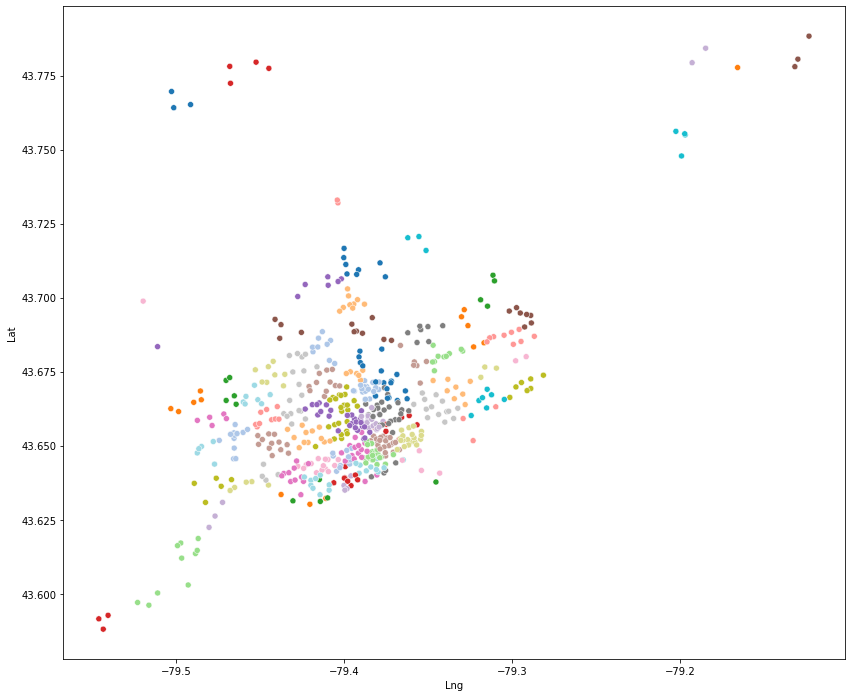

In [586]:
scaler = MinMaxScaler()

# Now that we are using different units, scale them all.

groupby['nlat'] = 5 * scaler.fit_transform(np.array(groupby['Lat'].values).reshape(-1,1))
groupby['nlng'] = 5 * scaler.fit_transform(np.array(groupby['Lng'].values).reshape(-1,1))
groupby['ncount'] = scaler.fit_transform(np.array(groupby['Trips'].values).reshape(-1,1))

print(groupby[['nlat', 'nlng', 'ncount']])

kmeans = KMeans(n_clusters=80)
kmeans.fit(groupby[['nlat', 'nlng', 'ncount']])

groupby['cluster'] = kmeans.labels_

plt.figure(figsize=(14,12)) 
sns.scatterplot(x='Lng', y='Lat', data=groupby, hue='cluster', legend=None, palette='tab20')

In [587]:
cleandf['Start Cluster'] = cleandf['Start Station Id'].apply(lambda x: groupby.loc[x, 'cluster'])
cleandf['End Cluster'] = cleandf['End Station Id'].apply(lambda x: groupby.loc[x, 'cluster'])

Drop information that we would not know at time of departure as well as the station ids (too many to categorize).

In [588]:
cleandf = cleandf.drop(['Start Station Id', 'End Station Id', 'Start Station Name', 'End Station Name', 
              'Start Time', 'End Time', 'End Station Lat', 'End Station Lng'], axis=1)

Categorize the clusters.

In [589]:
cleandf['Start Cluster'] = cleandf['Start Cluster'].apply(lambda x: str.format('SC-{}', x))
cleandf['End Cluster'] = cleandf['End Cluster'].apply(lambda x: str.format('EC-{}', x))

dummies = pd.get_dummies(cleandf['Start Cluster'], drop_first=True)
cleandf = pd.concat([cleandf.drop('Start Cluster', axis=1), dummies], axis=1)

dummies = pd.get_dummies(cleandf['End Cluster'], drop_first=True)
cleandf = pd.concat([cleandf.drop('End Cluster', axis=1), dummies], axis=1)

### Selecting Users

Several several users with the most trips for more training data.

In [591]:
# Look for some large data sets to attempt training
# cleandf.groupby('Subscription Id').count()['Casual Member'].sort_values(ascending=False)

user_one = cleandf[cleandf['Subscription Id'] == 536110].drop('Subscription Id', axis=1)
user_two = cleandf[cleandf['Subscription Id'] == 536202].drop('Subscription Id', axis=1)

user_of_interest = user_one

### Train test split

In [273]:
from sklearn.model_selection import train_test_split

In [596]:
X = user_of_interest.iloc[:,0:111].values
Y = user_of_interest.iloc[:,111:].values

In [599]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

### Scaling Data

In [379]:
from sklearn.preprocessing import MinMaxScaler

In [600]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Creation

In [284]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [661]:
model = Sequential()

# 111 features input
model.add(Dense(111, activation='relu'))

model.add(Dense(111, activation='relu'))
model.add(Dropout(0.5))

# model.add(Dense(111, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(111, activation='relu'))
# model.add(Dropout(0.5))

# Output, num classes
model.add(Dense(79, activation='sigmoid'))

# >2 labels
model.compile(loss='categorical_crossentropy', optimizer='adam')

Using an early stop, helps avoid overfit as we don't know what a reasonable number of epochs would be.

In [662]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [663]:
model.fit(x=X_train, y=Y_train, epochs=600, validation_data=(X_test,Y_test), batch_size=256, callbacks=[early_stop])

Train on 780 samples, validate on 195 samples
Epoch 1/600
780/780 [==============================] - 1s 2ms/sample - loss: 4.3874 - val_loss: 4.3352
Epoch 2/600
780/780 [==============================] - 0s 190us/sample - loss: 4.3201 - val_loss: 4.2733
Epoch 3/600
780/780 [==============================] - 0s 197us/sample - loss: 4.2559 - val_loss: 4.2056
Epoch 4/600
780/780 [==============================] - 0s 191us/sample - loss: 4.1823 - val_loss: 4.1273
Epoch 5/600
780/780 [==============================] - 0s 193us/sample - loss: 4.0949 - val_loss: 4.0350
Epoch 6/600
780/780 [==============================] - 0s 193us/sample - loss: 3.9987 - val_loss: 3.9241
Epoch 7/600
780/780 [==============================] - 0s 205us/sample - loss: 3.8847 - val_loss: 3.7884
Epoch 8/600
780/780 [==============================] - 0s 190us/sample - loss: 3.7450 - val_loss: 3.6225
Epoch 9/600
780/780 [==============================] - 0s 251us/sample - loss: 3.5697 - val_loss: 3.4188
Epoch 10/60

Epoch 78/600
780/780 [==============================] - 0s 178us/sample - loss: 1.1373 - val_loss: 1.2282
Epoch 79/600
780/780 [==============================] - 0s 167us/sample - loss: 1.1561 - val_loss: 1.2309
Epoch 80/600
780/780 [==============================] - 0s 166us/sample - loss: 1.1609 - val_loss: 1.2336
Epoch 81/600
780/780 [==============================] - 0s 162us/sample - loss: 1.1333 - val_loss: 1.2282
Epoch 82/600
780/780 [==============================] - 0s 170us/sample - loss: 1.1307 - val_loss: 1.2196
Epoch 83/600
780/780 [==============================] - 0s 161us/sample - loss: 1.1457 - val_loss: 1.2198
Epoch 84/600
780/780 [==============================] - 0s 166us/sample - loss: 1.0936 - val_loss: 1.2174
Epoch 85/600
780/780 [==============================] - 0s 164us/sample - loss: 1.1374 - val_loss: 1.2164
Epoch 86/600
780/780 [==============================] - 0s 166us/sample - loss: 1.1136 - val_loss: 1.2192
Epoch 87/600
780/780 [========================

### Analyzing Performance

<AxesSubplot:>

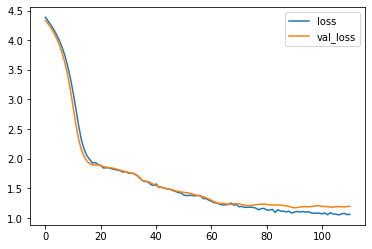

In [664]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [665]:
predictions = model.predict_classes(X_test)

In [667]:
from sklearn.metrics import classification_report

reformatted = np.zeros([195,79])

r = 0
for i in predictions:
    reformatted[r,i] = 1
    r += 1
    
print(classification_report(Y_test, reformatted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.37      0.86      0.52        22
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.56      0.20      0.30        49
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/Users/mickeydang/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mickeydang/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusions

The model had an average f1-score of 55% with 195 data points used for training (30% of the entire dataset). 
The quickest step for improving accuracy would include adding more datapoints.

By breaking down the results, we see that the vast majority of test data had four clusters which drove the model to fit them tightly (all clusters outside the top 4 were infrequently travelled and had no guesses). 

Although some tweaks were attempted to make the model fit better, one bottleneck with the current approach may be the lack of feaures with stronger correlations to catch these edge clusters. Using other time data such as month, as well as incorporating trickier features such as the number of times the user has already ridden their bike on the same day, could offer more features with helpful insight into user behaviour.